Here I give an example of plotting the DFT+DMFT spectral function $A(k,\omega)$ along a high symmetry k path (effectively a correlated version of a band structure) for $Sr_2RuO_4$. 

The DFT calculations were done with Wien2k, then Wannier90 was used to construct MLWFs for the Ru-$t_{2g}$ bands, and then Triqs was used to do a DMFT calculation. The self energy was analytically continued using the maximum entropy method.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from h5 import HDFArchive
from triqs.gf import *

In [46]:
#construct k point path in the conventional BZ
conventional_kpoints = []
for i in range(101):
    conventional_kpoints.append([i/200., 0., 0.]) #Gamma to X
for i in range(1,101):
    conventional_kpoints.append([.5, i/200., 0.]) #X to M
for i in range(139,-1,-1):
    conventional_kpoints.append([i/280., i/280., 0.]) #M to Gamma
for i in range(1,101):
    conventional_kpoints.append([0., 0., i/200.]) #
conventional_kpoints = np.asarray(conventional_kpoints)

# express the k points in terms of the primitive reciprocal vectors
primitive_kpoints = np.zeros((441,3))
for i in range(441):
    primitive_kpoints[i,0] = .5*(conventional_kpoints[i,2] + conventional_kpoints[i,1] - conventional_kpoints[i,0])
    primitive_kpoints[i,1] = .5*(conventional_kpoints[i,0] + conventional_kpoints[i,2] - conventional_kpoints[i,1])
    primitive_kpoints[i,2] = .5*(conventional_kpoints[i,1] + conventional_kpoints[i,0] - conventional_kpoints[i,2])
    
#find the linear distance of each k point along the path
a = 7.296800
c = 24.040718
linear_distance = np.zeros(441)
for i in range(1,441):
    linear_distance[i] = (linear_distance[i-1] + np.sqrt((conventional_kpoints[i,0]- conventional_kpoints[i-1,0])**2 +
                                                         (conventional_kpoints[i,1]- conventional_kpoints[i-1,1])**2 +
                                                         (conventional_kpoints[i,2]*a/c- conventional_kpoints[i-1,2]*a/c)**2))


with HDFArchive('Sr2RuO4_w90_b50_k400_DMFT.h5', 'r') as A: #file containing DMFT results
    dc = A['DMFT_results']['dc_avg'][0]['up'][0,0]
    mu = A['DMFT_results']['mu_avg']
with HDFArchive('Sr2RuO4_Sigma_MaxEnt_w90_b50_k400.h5','r') as A: #file containing analytically continued Sigma
    Sigma_xy = A['Sigma_w_xy']
    Sigma_xz = A['Sigma_w_xz']

mesh = Sigma_xy.mesh
wvals = [i for i in mesh.values()]
Sigma = GfReFreq(mesh = mesh, target_shape=[3,3])
Sigma.zero()
Sigma[0,0] << Sigma_xy[0,0] - dc
Sigma[1,1] << Sigma_xz[0,0] - dc
Sigma[2,2] << Sigma_xz[0,0] -dc

# construct Wannier H(R-R') in an array
mx = 7
my = 7
mz = 10
dim = 3
skip = 78
nx = 2*mx+1
ny = 2*my+1
nz = 2*mz+1

hr = np.loadtxt('Sr2RuO4_hr.dat', skiprows = skip) #load file with Wannier Hamiltonian
Hrij = np.zeros((nx,ny,nz,dim,dim), dtype = np.complex_)
for line in hr:
    rxind = int(line[0]) + mx
    ryind = int(line[1]) + my
    rzind = int(line[2]) + mz
    i = int(line[3]) - 1
    j = int(line[4]) - 1
    Hrij[rxind,ryind,rzind,i,j] = line[5] + 1j*line[6]
del hr

Nk = primitive_kpoints.shape[0]
Nw = len(wvals)
Akw = np.zeros((Nk,Nw))

wannier_bands = np.zeros((primitive_kpoints.shape[0], 3))
Gkw = Sigma.copy()
#loop over k points
for ik, k in enumerate(primitive_kpoints):
    
    #find H(k) for given k point by fourier transforming H(R-R')
    Hexp = np.empty_like(Hrij,dtype = np.complex_)
    for xi in range(nx):
        for yi in range(ny):
            for zi in range(nz):
                r = (xi-mx, yi-my, zi-mz)
                eikr = np.exp(-1j*2*np.pi*k.dot(r))
                Hexp[xi, yi, zi, :, :] = eikr
    Hkrij = Hrij * Hexp
    Hk = np.sum(Hkrij, axis = (0,1,2))
    
    #set wannier bands as eigenvalues of H(k)
    wannier_bands[ik] = np.linalg.eigvalsh(Hk)
    
    Gkw << inverse(Omega - Hk + mu - Sigma)
    Akw[ik] = -np.trace(Gkw.data, axis1=1, axis2=2).imag/np.pi

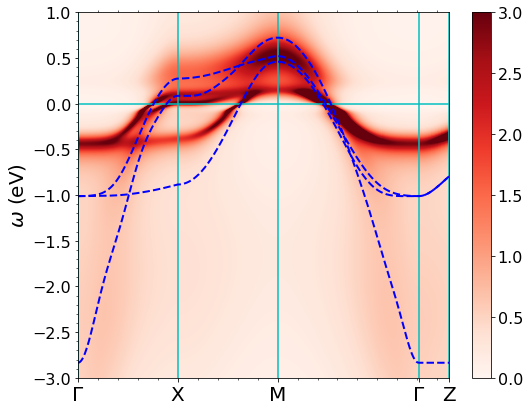

In [47]:
plt.figure(figsize = (8,6))
plt.rc('font', size = 16)

color_map = 'Reds'
wband = np.tile(np.array(wvals), (Nk,1))
kband = np.tile(linear_distance,(Nw,1)).T
plt.pcolormesh(kband, wband, Akw,cmap=color_map, shading='auto')
plt.clim(0,3)
plt.ylim(-3,1)
plt.ylabel('$\omega$ (eV)', fontsize = 20)

ksp = [0,100,200,340,440]
ksp_name = ['$\Gamma$', 'X', 'M', '$\Gamma$', 'Z']
plt.xticks([linear_distance[i] for i in ksp], ksp_name, fontsize = 20)
plt.xlim(linear_distance[0], linear_distance[-1])
for k in ksp:
     plt.axvline(linear_distance[k],color='c')
        
plt.axhline(0, color = 'c')

plt.minorticks_on()
plt.gca().tick_params(axis='x',which='minor',bottom='off',top='off')
plt.tight_layout()
plt.colorbar()

for i in range(3):
    plt.plot(linear_distance, wannier_bands[:,i], '--b', lw = 2)
plt.show()

The Wannier bands are shown as blue dashed lines and the spectral function (correlated DMFT bands) is shown in red. The self energy strongly renomalizes and broadens the bands